In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import numpy as np

from sparcscore.pipeline.project import Project
from sparcscore.pipeline.workflows import CytosolSegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction
from sparcscore.pipeline.classification import CellFeaturizer
from sparcscore.pipeline.selection import LMDSelection

In [2]:
project_location = f"project"

project = Project(os.path.abspath(project_location),
                  config_path= "config_example4.yml",
                  overwrite=True,
                  debug=True,
                  segmentation_f=CytosolSegmentationCellpose,
                  extraction_f=HDF5CellExtraction,
                  classification_f=CellFeaturizer,
                  selection_f=LMDSelection
                  )

modifying config
[11/07/2024 12:49:52] Loading config from /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/config.yml
[11/07/2024 12:49:52] Loading classes from default classes path: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/segmentation/classes.csv
[11/07/2024 12:49:52] Setup output folder at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/extraction/data
[11/07/2024 12:49:52] current run: 0


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/project.py:152: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


In [3]:
#these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = ["./input_images/ch1.tif",
          "./input_images/ch2.tif",
          "./input_images/ch3.tif"]

project.load_input_from_file(images)

[11/07/2024 12:49:52] saved input_image: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/input_image.ome.zarr


In [4]:
project.input_image.dtype

dtype('uint16')

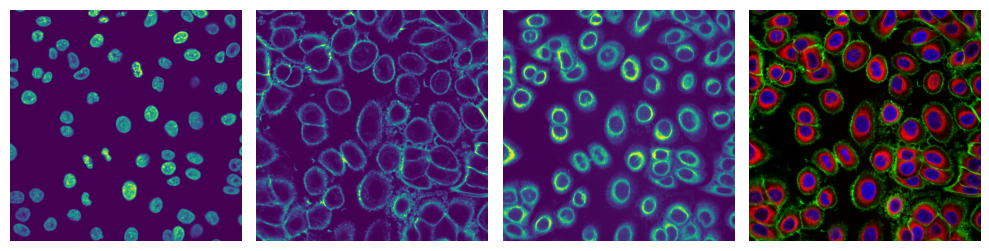

In [5]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color

def generate_composite(images, colors = [(0, 0, 1),(0, 1, 0), (1, 0, 0), (1, 0, 1)], plot = False):
    colorized = []
    for image, color in zip(images, colors):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized)-1):
        image += colorized[i+1]

    return(np.clip(image, 0, 1))

fig, axs = plt.subplots(1, 4, figsize = (10, 4));
axs[0].imshow(project.input_image[0]);
axs[0].axis("off");

axs[1].imshow(project.input_image[1]);
axs[1].axis("off");

axs[2].imshow(project.input_image[2]);
axs[2].axis("off");

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off");

fig.tight_layout()

[11/07/2024 12:50:03] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolSegmentationCellpose_bycm9d3w for CytosolSegmentationCellpose
[11/07/2024 12:50:03] running on default GPU.
[11/07/2024 12:50:03] Using MPS backend for segmentation.
[11/07/2024 12:50:03] GPU Status for segmentation: True
[11/07/2024 12:50:03] Segmenting nuclei using the following model: nuclei
[11/07/2024 12:50:15] Segmenting cytosol using the following model: cyto2
[11/07/2024 12:51:44] Filtering generated nucleus and cytosol masks based on size.
[11/07/2024 12:51:44] No confidence interval specified for nucleus mask filtering, using default value of 0.95
[11/07/2024 12:51:44] Automatically calculating thresholds for filtering of nuclei based on a fitted normal distribution with a confidence interval of 95.0%.
[11/07/2024 12:51:44] Removed 5 nuclei as they fell outside of the threshold range [ 1444.16590584 33445.79873331].
[11/07/2024 12:51:44] No confidence interval sp

/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/workflows.py:994: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[11/07/2024 12:51:45] Filtering status for this segmentation is set to True.
[11/07/2024 12:51:45] Filtering has been performed during segmentation. Nucleus and Cytosol IDs match. No additional steps are required.
[11/07/2024 12:51:45] Saved cell_id classes to file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/segmentation/classes.csv.
[11/07/2024 12:51:45] === finished segmentation ===
[11/07/2024 12:51:45] save_zarr attribute not found
[11/07/2024 12:51:45] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolSegmentationCellpose_bycm9d3w'>


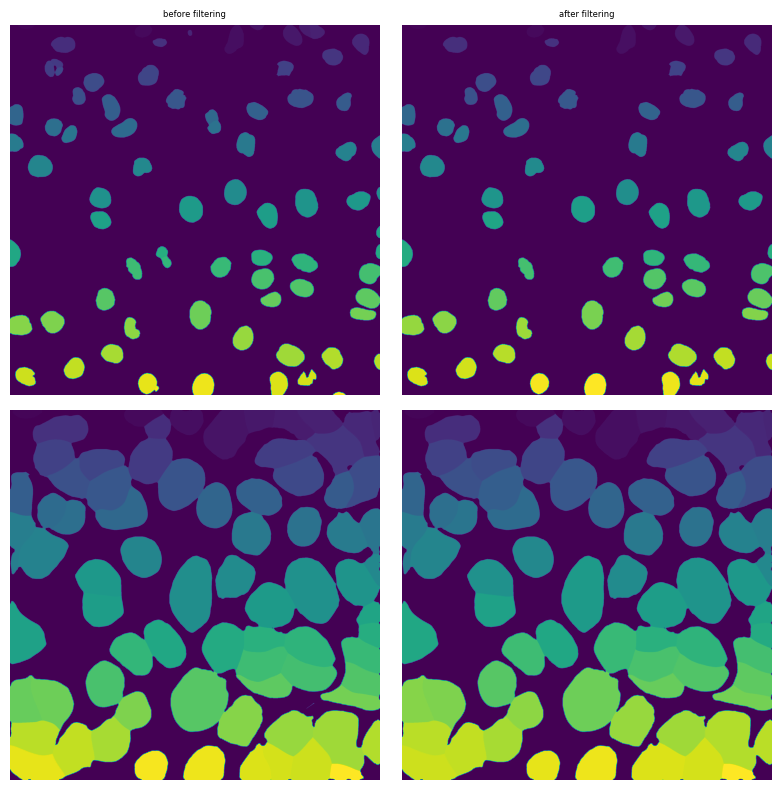

In [6]:
project.segment()

<HDF5 dataset "labels": shape (2, 2159, 2159), type "<u4">


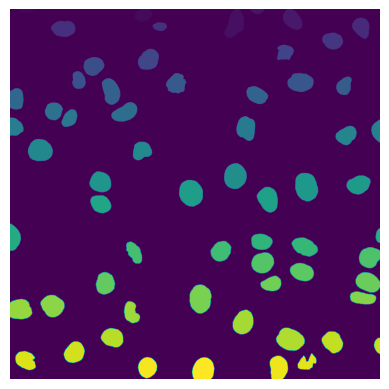

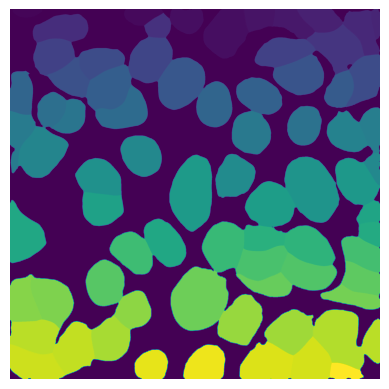

In [7]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")
    print(segmentation)

    plt.figure()
    plt.imshow(segmentation[0])
    plt.axis("off")

    plt.figure()
    plt.imshow(segmentation[1])
    plt.axis("off")

In [8]:
project.extract()

[11/07/2024 12:53:42] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_s85nwbjo for HDF5CellExtraction
[11/07/2024 12:53:42] Using channel label <HDF5 dataset "channels": shape (3, 2159, 2159), type "<u2">
[11/07/2024 12:53:42] Using segmentation label <HDF5 dataset "labels": shape (2, 2159, 2159), type "<u4">
[11/07/2024 12:53:42] Created new data directory /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/extraction/data
[11/07/2024 12:53:42] Setup output folder at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/extraction/data
[11/07/2024 12:53:42] Started extraction
[11/07/2024 12:53:42] Loading segmentation data from /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/segmentation/segmentation.h5
[11/07/2024 12:53:42] Finished loading channel data (3, 2159, 2159)
[11/07/2024 12:53:42] Finished loading label data (2, 2159, 2159)
[11/07/2024 12:53:42]

/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/extraction.py:652: RuntimeWarning: invalid value encountered in cast
  px_centers = np.round(center_nuclei).astype(int)


cell id 5 is too close to the image edge to extract. Skipping this cell.cell id 2 is too close to the image edge to extract. Skipping this cell.cell id 10 is too close to the image edge to extract. Skipping this cell.cell id 3 is too close to the image edge to extract. Skipping this cell.[11/07/2024 12:53:44] Extracting dataset 0cell id 12 is too close to the image edge to extract. Skipping this cell.

Processing cell batches:   0%|          | 0/63 [00:00<?, ?it/s]

cell id 11 is too close to the image edge to extract. Skipping this cell.cell id 4 is too close to the image edge to extract. Skipping this cell.cell id 9 is too close to the image edge to extract. Skipping this cell.cell id 25 is too close to the image edge to extract. Skipping this cell.cell id 33 is too close to the image edge to extract. Skipping this cell.cell id 32 is too close to the image edge to extract. Skipping this cell.
cell id 34 is too close to the image edge to extract. Skipping this cell.
cell id 35 is too close to the image edge to extract. Skipping this cell.





cell id 41 is too close to the image edge to extract. Skipping this cell.

cell id 46 is too close to the image edge to extract. Skipping this cell.
cell id 47 is too close to the image edge to extract. Skipping this cell.


cell id 54 is too close to the image edge to extract. Skipping this cell.cell id 1 is too close to the image edge to extract. Skipping this cell.cell id 58 is too close to the image edg

(35, 5, 400, 400)


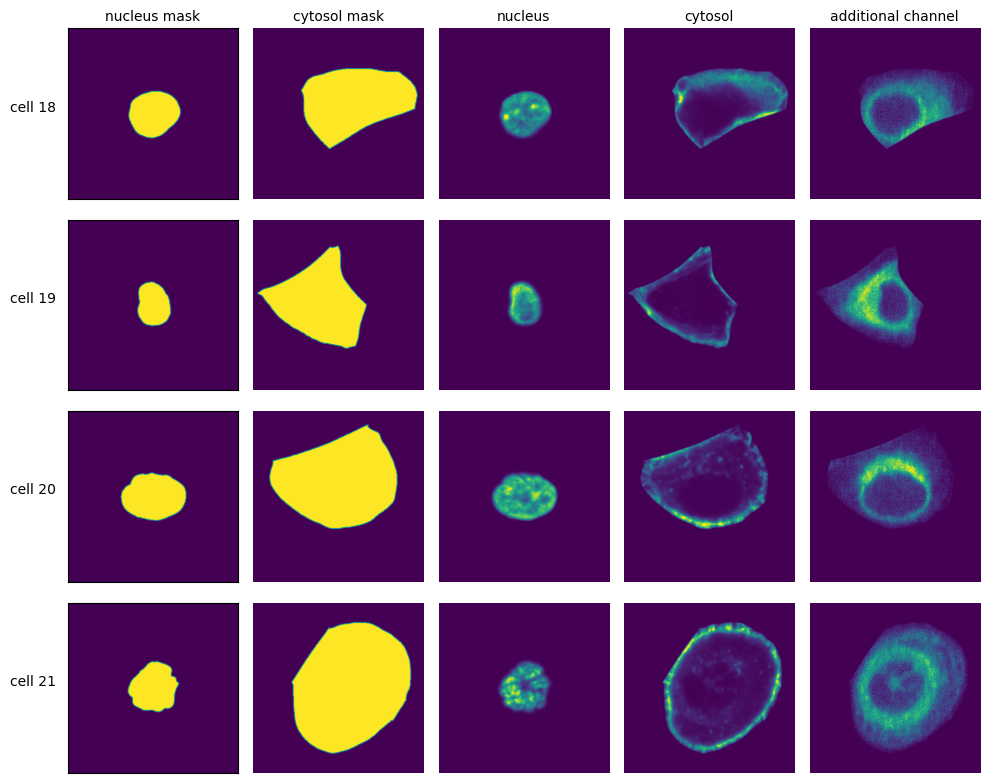

In [14]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize = (5*2, len(n_cells)*2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]
    
    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img, vmin = 0, vmax = 1)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize = 10, rotation = 0, labelpad = 25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")
        
            if i == 0:
                axs[i, n].set_title(labels[n], fontsize = 10)
            
            
    fig.tight_layout()

In [10]:
project.classify(accessory = [(), (), ()])

[11/07/2024 12:54:01] Started classification
[11/07/2024 12:54:01] starting with run 0
[11/07/2024 12:54:01] channel_classification: 4
[11/07/2024 12:54:01] batch_size: 900
[11/07/2024 12:54:01] dataloader_worker_number: 0
[11/07/2024 12:54:01] inference_device: cpu
[11/07/2024 12:54:01] screen_label: Ch3_Featurization
[11/07/2024 12:54:01] 0 different accessory datasets specified
[11/07/2024 12:54:01] loading /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/extraction/data
[11/07/2024 12:54:01] Adding hdf5 file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/extraction/data/single_cells.h5 to index...
Total: 35
0: 35

[11/07/2024 12:54:01] start processing 1 batches
[11/07/2024 12:54:01] finished processing


/Users/sophia/mambaforge/envs/SPARCSspatial-dev/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


In [12]:
#load classification results
results = pd.read_csv(f"{project_location}/classification/0_Ch3_Featurization/calculated_features.csv", index_col = 0)
results

,nucleus_area,cytosol_area,mean,median,quant75,quant25,summed_intensity_nucleus_area,summed_intensity_cytosol_area,summed_intensity_nucleus_area_normalized,summed_intensity_cytosol_area_normalized,label,cell_id
0,17439.0,47697.0,0.078683,0.000000,0.053558,0.0,5993.9067,12589.2290,0.343707,0.263942,0,37
1,13505.0,48054.0,0.075777,0.000000,0.044647,0.0,3624.3562,12124.3230,0.268371,0.252306,0,27
2,9618.0,30993.0,0.043946,0.000000,0.000000,0.0,2349.4890,7031.3657,0.244280,0.226869,0,59
3,10701.0,48310.0,0.083245,0.000000,0.054047,0.0,3880.4702,13319.2730,0.362627,0.275704,0,36
4,11123.0,46609.0,0.060939,0.000000,0.035706,0.0,3313.9650,9750.2920,0.297938,0.209193,0,24
5,10895.0,33189.0,0.068972,0.000000,0.000000,0.0,4154.8213,11035.5850,0.381351,0.332507,0,49
6,9603.0,47420.0,0.093023,0.000000,0.041229,0.0,3759.6404,14883.7240,0.391507,0.313870,0,53
7,13898.0,48755.0,0.061955,0.000000,0.044647,0.0,3687.5723,9912.8430,0.265331,0.203319,0,31
8,13151.0,52101.0,0.082616,0.000000,0.062447,0.0,4238.6406,13218.5120,0.322306,0.253709,0,57
9,11462.0,41617.0,0.078814,0.000000,0.000003,0.0,3655.6940,12610.2150,0.318940,0.303006,0,44


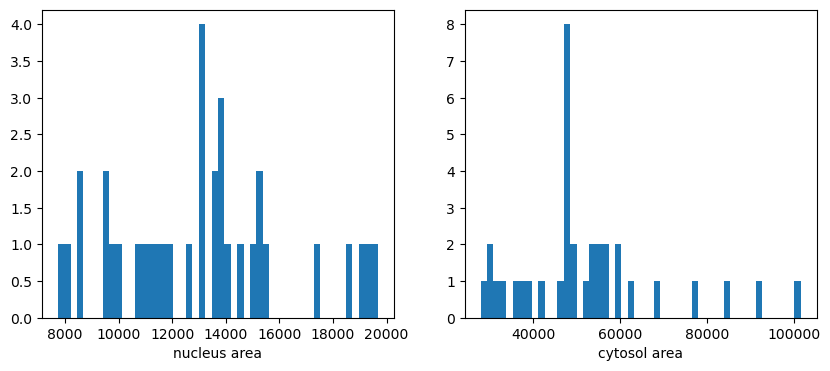

In [13]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
axs[0].hist(results["nucleus_area"], bins = 50)
axs[0].set_xlabel("nucleus area");

axs[1].hist(results["cytosol_area"], bins = 50)
axs[1].set_xlabel("cytosol area");